# Reproducing GPT-2 From Scratch

[Video](https://www.youtube.com/watch?v=l8pRSuU81PU)<br>
[Build-NanoGPT Repository](https://github.com/karpathy/build-nanogpt)<br>
[NanoGPT Repository](https://github.com/karpathy/nanogpt)<br>
[Errata](https://github.com/karpathy/build-nanogpt?tab=readme-ov-file#errata)<br>
[Discussions](https://github.com/karpathy/build-nanogpt/discussions)<br>
[Discord](https://discord.com/invite/3zy8kqD9Cp)

Notebook by [mk2112](https://github.com/mk2112)

## Table of Contents

- [GPT-2 Architecture Overview](#gpt-2-architecture-overview)
  - [Is Attention All We Need?](#is-attention-all-we-need)
  - [Configuration](#configuration)
  - [The GPT Class](#the-gpt-class)
  - [The Block Class](#the-block-class)
  - [The MLP Class](#the-mlp-class)
  - [The CausalSelfAttention Class](#the-causalselfattention-class)
  - [Tokenization](#tokenization)
- [Resetting the Weights](#resetting-the-weights)
- [Creating Tokenized Training Input](#creating-tokenized-training-input)
- [Calculating the Loss](#calculating-the-loss)
- [Optimization](#optimization)
  - [Sanity Check](#sanity-check)
  - [Data Loading](#data-loading)
- [Bugfixing](#bugfixing)
  - [Token Embedding Layer and Linear Output Layer are Identical?!](#token-embedding-layer-and-linear-output-layer-are-identical)
  - [Weight initialization](#weight-initialization)
- [Optimizing Model Training](#optimizing-model-training)
  - [NVIDIA Tensor Cores and TensorFloat32](#nvidia-tensor-cores-and-tensorfloat32)
  - [Decreasing Memory Movements](#decreasing-memory-movements)
  - [PyTorch Compiling](#pytorch-compiling)
  - [FlashAttention and a Caveat of Compilation](#flashattention-and-a-caveat-of-compilation)
  - [Removing 'ugly' numbers](#removing-ugly-numbers)
  - [Algorithmic Adaptations](#algorithmic-adaptations)
    - [Adam/AdamW Optimizer Configuration](#adamadamw-optimizer-configuration)
    - [Global Norm Clipping](#global-norm-clipping)
    - [Learning Rate Decay](#learning-rate-decay)
    - [Dynamic Batch Size Increase](#dynamic-batch-size-increase)
    - [Data Loading](#data-loading)
    - [Weight Decay and Fused AdamW](#weight-decay-and-fused-adamw)
    - [Gradient Accumulation for Simulating Large Batch Sizes](#gradient-accumulation-for-simulating-large-batch-sizes)
- [Training on Multiple GPUs](#training-on-multiple-gpus)
  - [Introducing DistributedDataParallel](#introducing-distributeddataparallel)
  - [Adapting the Gradient Accumulation](#adapting-the-gradient-accumulation)
  - [Adapting the DataLoader](#adapting-the-dataloader)
  - [Fully Integrating DistributedDataParallel](#fully-integrating-distributeddataparallel)
  - [Distributing the Training Loop](#distributing-the-training-loop)
- [We Definitely Need More Data](#we-definitely-need-more-data)
  - [DataLoader Adjustments](#dataloader-adjustments)
- [Eval, Logging and Visualization](#eval-logging-and-visualization)
  - [HellaSwag Eval](#hellaswag-eval)
  - [Visualizing Training Progress](#visualizing-training-progress)
- [Opportunities for Optimization and Enhancement](#opportunities-for-optimization-and-enhancement)

<br>

---

In 2019, OpenAI released version 2 of its General Pretrained Transformer (GPT-2) model.<br>
The release consisted of:
- a [blog post](https://openai.com/blog/better-language-models/),
- a [research paper \[Radford et al. 2019\]](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), and
- a [GitHub repository](https://github.com/openai/gpt-2).

Moreover, GPT-2 brought not one, but four models of different sizes:
- `124M` (124 million parameters),
- `355M` (355 million parameters),
- `774M` (774 million parameters), and
- `1558M` (1558 million parameters).

One of the reasons models like GPT-2 are relased as a set of incrementally larger models is to allow for<br>
experiments with the different sized models to compare how their performance differs on different tasks.<br>
This can indicate the capacity needed to attain certain skills, and it can hint at<br>
the direction in which design improvements could be most effective in the future.

In this notebook, we will reproduce the `124M` model.<br>
Crazy enough, this model was state-of-the-art in 2019, and you can train it in $\approx 1$ hour today for $\approx \$10$ (if you rent some GPUs).<br>
To really get the training part right though, we will not only refer to [\[Radford et al. 2019\]](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), but also to [\[Brown et al. 2020\]](https://arxiv.org/abs/2005.14165), the paper that introduced GPT-3.

## GPT-2 Architecture Overview

The original paper describes the GPT-2 model series as follows:<br>
![](./images/gpt2_table_sm.png)<br>
Source: [\[Radford et al. 2019\]](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

Note that the table calls the `124M` model `117M`. OpenAI back then just didn't count the parameters correctly.<br>
But, correctly, the table states that the small model has $12$ transformer layers and a hidden size of $768$ units.

This means:

- The small model has $12$ transformer decoder blocks stacked on top of each other
    - Each block individually consists of masked multi-head attention, multi-head attention, feed-forward and normalization layers
    - Within each block, residual connections are used around normalized attention layers and feed-forward layers
    - Each block's total output is passed to the next block as input
- Each transformer block also has $768$ hidden units
    - The value $768$ represents the dimensionality of the embeddings within each layer, i.e. the space we map our tokens into to represent their meaning
    - $768$ also sets the size of input/output vectors for the self-attention mechanism and feed-forward layers
    - In other words, it's the **bandwith of the model across layers**

If any of the above is unclear, don't worry about it.<br>
See [7 - GPT From Scratch](../7%20-%20GPT%20From%20Scratch/7%20-%20GPT.ipynb) for details.

Going from the vanilla transformer architecture, you can start to think of the GPT-2 model looking somewhat (not exactly, we will get to that) like this:<br>
![](./images/gpt2_layout_general.png)<br>
Source: [dzlab.github.io](https://dzlab.github.io/ml/2020/07/25/gpt3-overview/)

The original [GPT-2 repository](https://github.com/openai/gpt-2) released the model in TensorFlow.<br>
We will have a look at [HuggingFace's GPT-2 Implementation](https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py) instead.<br>
Somewhat more readable. Somewhat.

Let's see how things work in HuggingFace's implementation.

In [1]:
from transformers import GPT2LMHeadModel
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M parameters, for "gpt2-xl" the gold model
sd_hf = model_hf.state_dict() # Dictionary of the model's weight/bias tensors

for identifier, tensor in sd_hf.items():
    print(identifier, tensor.shape)

# Print some GPT-2 weights
print('\n', sd_hf["transformer.wpe.weight"].view(-1)[:20])

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

This seems to not really tell us much at first glance.

But think of the above output like this:
- `wte` is the weight matrix for the *token embeddings*, 
- `wpe` is the weight matrix for the *positional embeddings*, 
- `h` is the hidden state. 
- The rest is transformer blocks.

We can therefore say that GPT-2 has a vocabulary size of $50257$ tokens, each being mapped to a representing embedding vector of size $768$.<br>
Furthermore, each token can be attended to by $1024$ prior tokens in a sequence. GPT-2's context size is $1024$ tokens.

If you don't know what any of that means, don't worry about it, refer to [8 - GPT Tokenizer](../8%20-%20GPT%20Tokenizer/8%20-%20Tokenization.ipynb).

Let's actually take a look at the positional embedding matrix by plotting it:

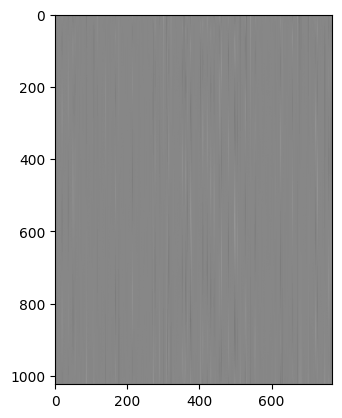

In [4]:
plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray");

We need to learn these positional embeddings because by default, transformers don't process data sequentially.<br>
In fact, transformers would have no idea of the concept of sequence (contrary to e.g. RNNs/LSTMs) if we didn't provide them with positional information.<br>

To solve this, we encode not only the token meaning itself, but also it's position for the transformer to be able to better take semantics into account.<br>
We've plotted the positional embedding matrix informing about the position of each token above.<br>
Positional embeddings are learned for the $1024$ context size and across the full $768$ hidden size.<br>
The positional embeddings are simply added to the token embedding values to form the input to the transformer.

> Somewhat counterintuitively, the positional embeddings are not fixed, but also learned from a random starting setup, just like the token embeddings themselves.<br>

During training, it emerges that for every hidden position and across all context entries, a sinusoidal function is encoded.<br>
Each encoding is slightly different in the function it represents, because each position corresponds to an characteristic information about the position and is processed by the transformer to recover relative nuances deemed important by encountered patterns.<br>

We can say that the encoded sinusoidal functions express relative importance through the parameters in the context size wide embeddings.<br>
And, to add to that, [GPT-2's Positional Embedding Matrix encodes a Helix](https://www.lesswrong.com/posts/qvWP3aBDBaqXvPNhS/gpt-2-s-positional-embedding-matrix-is-a-helix).

**Why aren't the positional embeddings just hard-coded from the beginning? Isn't learning the order of tokens something we could easily express ourselves directly, making optimization for it a waste of time?**

It is possible to hard-code information per each hidden state into a model.<br>
This was done e.g. with the original [Transformer model\[Vaswani et al. (2017)\]](https://arxiv.org/abs/1706.03762) through hard-coding sinusoidal functions.<br>

However, a learning process allows for discovery of useful properties (like those of fixed sinusoidal encodings) from token distributions directly.<br>
Scaling with the training set size and quality now, this technique now can inform across positional embeddings with additional nuances beyond the 'rigid' position-relationship embedding as such.

**Why sinusoidal functions? Why are these structures used to encode positions and why do their estimates emerge from learning too?**

Let's get one thing out of the way here: Each positional embedding is $768$-dimensional. The context size is $1024$, meaning we have $1024$ of these $768$ embeddings.<br>
The sinusoidal characteristics emerge not per each position embedding, but across all of them when looking per hidden dimension. I graphed this down below to show that.
The sinusoidal functions must therefore be representing something akin to inter-position relationships emerging from intra-position values at that hidden dimension.

With that out of the way, sinusoidal functions consist of combinations of sine and cosine waves.<br>
The space of possible combinations is infinite, implying that each inter-embedding relationship could be encoded uniquely.<br>
That's good, that's what we need here.<br>
We could argue that this would also work with randomly initialized embeddings. This notion breaks down quickly, though.<br>
See, when we are optimizing our embeddings, we actually start out randomly initialized across all embeddings, but the optimization we perform still has sinusoidal functions emerge across the embeddings.<br>
Therefore, these functions must be representing relationships better than random embeddings in some way. But how exactly?

First, each sinusoidal function is expressed across the full context size. One sinusoidal function per hidden state means we have $768$ of these.<br>
Sinusoidal functions, when learnt, are a result of gradient descent optimization, which itself requires differentiable functions.<br>
Optimizations emitted from this process are necessarily continuous, specifically enabling (continuous and differentiable) sinusoidal function estimations to emerge across the embedding space.<br>
As sinusoidal functions are continuous, different importances between context positions are expressed as being continuous too.<br>
This means is that sinusoidal functions make it easy to compute relative importances between any two positions both local and long-range across the context size.<br>

> Sinusoidal functions serve as an emulation of the continuous nature of language and are differentiable as a result of the optimization we perform to attain them, coincidentally enabling the model to very well express relative importances between any two positions smoothly.

**I can't wrap my head around the helix thing for GPT-2. What's the deal with that?**

We said that across each of the $768$ hidden states in the positional embeddings a sinusoidal function is emulated.<br>
Now, if we shift our focus back from looking across positional embeddings to looking per each embedding and we squash each $768$-dimensional embedding into just $3$ dimensions, we can plot the embeddings, and they form a continuous curve that rotates around an axis while moving along it. Each positional embedding has $768$ values, each contributing to a respective sinusoidal function. The positional embeddings thus captures a step in time across multiple functions, one per hidden state. The embedding therefore captures both the continuous nature of - and across - positions in a sequence, with all embeddings together forming the periodicity we expect in positional encodings (periodicity across the sequence, i.e. between the embeddings).

Let's now go and plot three individual embedding dimensions (columns):

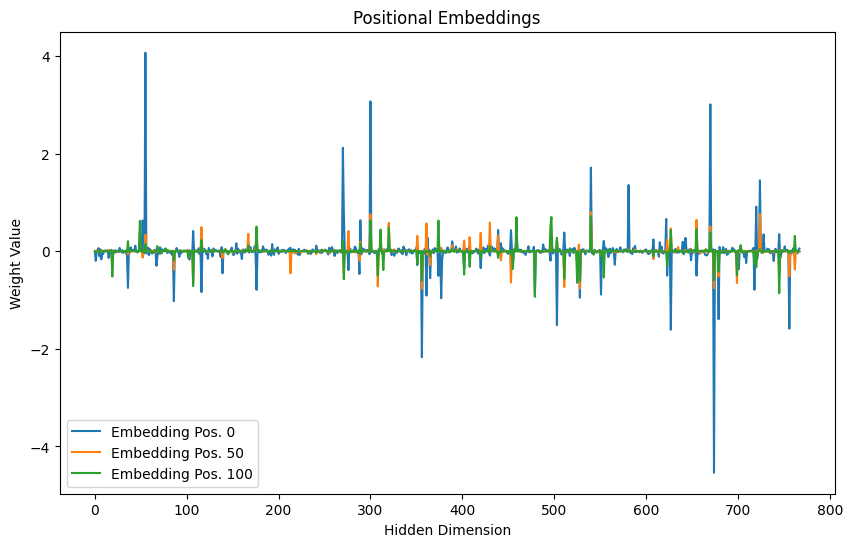

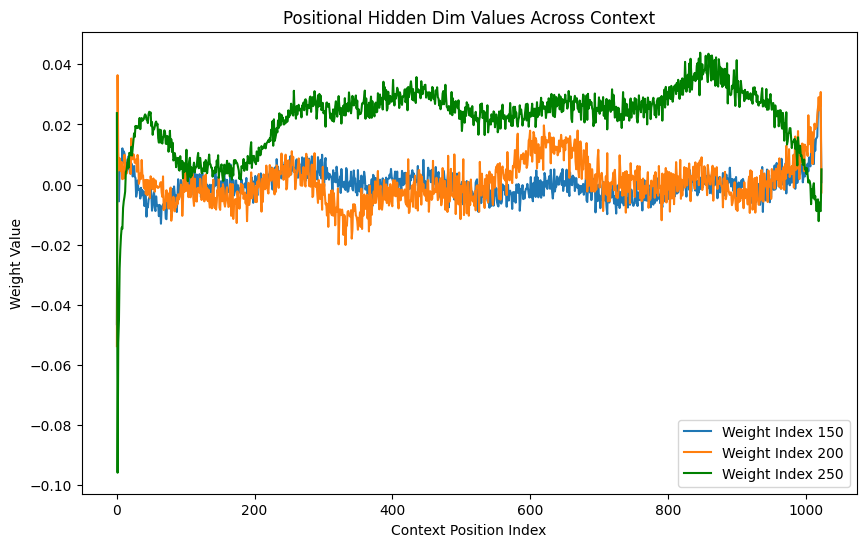

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(sd_hf["transformer.wpe.weight"][0, :], label="Embedding Pos. 0")
plt.plot(sd_hf["transformer.wpe.weight"][50, :], label="Embedding Pos. 50")
plt.plot(sd_hf["transformer.wpe.weight"][100, :], label="Embedding Pos. 100")
plt.legend()
plt.title("Positional Embeddings")
plt.xlabel("Hidden Dimension")
plt.ylabel("Weight Value")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sd_hf["transformer.wpe.weight"][:, 150], label="Weight Index 150")
plt.plot(sd_hf["transformer.wpe.weight"][:, 200], label="Weight Index 200")
plt.plot(sd_hf["transformer.wpe.weight"][:, 250], color="green", label="Weight Index 250")
plt.legend()
plt.title("Positional Hidden Dim Values Across Context")
plt.xlabel("Context Position Index")
plt.ylabel("Weight Value")
plt.show()

While the second plot's green graph may show some pattern across positions at column $250$, this does not mean that column $250$ encodes a full positional relationship.<br>
It's just a partial encoding of the $768$-dimensional function that expresses the positional relationships across all $1024$ embeddings.

The exact contribution of the single column in the positional encoding matrix is still vaguely understood at best.<br>
It is one instrument in an orchestra of $768$ instruments that together formulate the positional relationships.

And yet, interestingly, we can tell from this above second graph that this model is somewhat undertrained.<br>
We can say this because we see noise in the graphs themselves. We didn't just yet fully converge to sinusoidal function approximations.<br>

The parameters in the attention mechanism look like this:

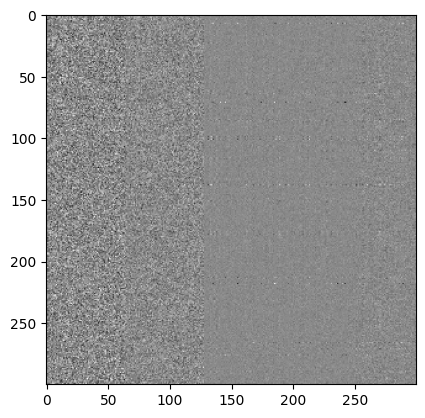

In [8]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300, :300], cmap="gray");

Let's play for a bit with sampling from HuggingFace's GPT-2 and see how that works:

In [10]:
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

### Is Attention All We Need?

Yes, pretty much.<br>
We will not get around to an in-depth look at the paper that started it all: [\[Vaswani et al. 2017\]](https://arxiv.org/abs/1706.03762).<br><br>
![](./images/transformer_gpt.png)

For GPT-2, we can discard everything outside the red box, i.e. the encoder and its connection into the decoder (through what's called cross-attention). 

> **GPT-2 is a decoder-only model.**

We will perform some slight changes to the default decoder.<br>
First, the layer norm is moved before the Masked Multi-Head Attention.<br>
While layer Norm is also placed before the Feed Forward Network, another Layer Norm is placed after the final Transformer block.

In total, we are aiming for this structure:<br>
![](./images/gpt2_layout_shuffle_shapes.png)

Ok, let's build this.<br>
I'll go through the implementation here class by class and then we puzzle everything together to form a working implementation.

### Configuration

First, we create a dataclass `GPTConfig` that will hold the values by which we configure our GPT model.<br>
The data class looks like this:

```python
@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
```

Here's what the parameters mean:
- `block_size`: the length of the sequence we want to process at once (context length)
- `vocab_size`: the number of possible input tokens
- `n_layer`: the number of transformer blocks stacked on top of each other within the GPT
- `n_head`: the number of heads per each multi-head attention mechanism (each has `n_layer` layers)
- `n_embd`: the dimension of the embeddings, i.e. the hidden size

### The GPT Class

The structure of our GPT-2 replication is realized within the `GPT` class:

```python
class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super(GPT, self).__init__()
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            # Token Embedding Layer
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            # Position Embedding Layer
            wpe = nn.Embedding(config.block_size, config.n_embd),
            # The Actual (12) Transformer blocks
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            # Final layer Norm before the output
            ln_f = nn.LayerNorm(config.n_embd),
        ))

        # The Prediction Head, Linear Layer but without Bias
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
```

We later on want to be able to load the weights from the HuggingFace version of GPT-2 into our model.<br>
Therefore, we need to build this class to stylistically be as close to the HuggingFace parameter setup as can be.<br>
To do just that, we build a Dictionary structure `transformer` that serves as a main container, housing everything but the Prediction Head `lm_head`.<br>
The `transformer` setup like this allows for `key:value` indexing like HuggingFace's `transformer.[wpe].weight`.

Specifically, we apply:
- Token Embedding Layer `wte`, mapping each token to an embedding vector of size `n_embd`,
- Position Embedding Layer `wpe`, mapping each position in the context size to an embedding vector of size `n_embd`,
- Module List `h` of `n_layer` Transformer Blocks, where we now index into numerically, as in HuggingFace's `transformer.h.[0].ln_1.weight`
- Layer Norm `ln_f` after the last Transformer block, before the output, as in HuggingFace's `transformer.ln_f.weight`
- Linear Layer `lm_head` as the prediction head, mapping normalized Transformer outputs back to the vocabulary size, as in HuggingFace's `lm_head.weight`

### The Block Class

We've seen that the Transformer Block inside the `GPT` class' `h` consists of Block objects.<br>
The `Block` class summarizes the Decoder Transformer block:

```python
class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
```

We perform layer normalization, feed that into the Self-Attention mechanism,<br>
feed that into another layer normalization and ultimately through an `MLP`, representing the Feed Forward Network.

Notice in the `forward()` how the residual connections aren't normalized here.<br>
This is better, The more residuals remain untouched, the less obstructed the gradient flow through them.<br>
Note, however, that we are also deviating from original Transformer paper with this.

### The MLP Class

The `MLP` is utilized within the Transformer block to build its Feed Forward network part.

```python
class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x
```

We connect two Linear layers that together form a hidden layer of size `n_embd * 4`, apply<br>
a `GELU` activation function between them and then map the output back to the original embedding size `n_embd`.

Just like the original, we use [GELU activation \[Hendrycks et al. 2016\]](https://arxiv.org/abs/1606.08415):<br>
![](https://pytorch.org/docs/stable/_images/GELU.png)

In relation to that, we talked about the dead neuron problem extensively in [4 - Makemore #3](../4%20-%20Makemore%203%20-%20Activations,%20BatchNorm/4%20-%20Makemore%20#3.ipynb).<br>
If ReLU-activated neurons hold negative values, these values are mapped flat-out to zero by the ReLU function. The neuron in turn will receive zero gradient, no update.<br>
Alternatively, GeLU always contributes at least an ever so slight gradient, thereby not abruptly hindering learning. This is why it's used in GPT-2.

### The CausalSelfAttention Class

The structural part that is missing now is the attention mechanism in each Transformer block.<br>
We implement this through the `CausalSelfAttention` class:

```python
class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # Key, Query, Value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # Regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.c_attn(x)
        q, k, v = qkv.chunk(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        # attention (materializes the large (T, T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y
```


Even though it may be not immediately obvious, this implementation mirrors the implementation we built in [7 - GPT from Scratch](../7%20-%20GPT%20From%20Scratch/7%20-%20GPT.ipynb).<br>
Back then, we utilized two classes: `Head` and `MultiHeadAttention`. This is refactored into a single class now, but its working essentially the same.

**But how does this work?**

Say, we have `context_size` many embedding vectors. Each vector is led through the linear layer `c_attn`, which per vector input emits three vectors of the input vector's size:
- `q` -> **Query**, representation of the word we want to calculate attention for,
- `k` -> **Key**, representation of each word in the context, from which we calculate the attention for the query, and
- `v` -> **Value**, representation of the content of each word in the context, which we want to include in the attention calculation.

Queries and Keys multiply each other via dot product. This gives us the attention scores for each word in the context.<br>
We then mask the part of the attention matrix below the diagonal, in order for each word to only be able to attend to prior words<br>
in the context and never expect information from (hypothetical) future words.<br>
The result is softmaxed to receive a distribution-like output, which is then multiplied with the Value vectors `v`.<br>
The weighted value vectors now get summed up. In other words, we effectively form a sum of values, weighted by attention.<br>
This sum is the **attention output**.

Long story short, the above code behaves equivalently to having an explicit `Head` class and concatenating each `Head`'s output to form the `MultiHead` input to its reshaping last linear layer.

All that is missing now for a GPT-2 replication is the `forward` function in the `GPT` class:

```python
    def forward(self, idx):
        # idx has shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is {self.config.block_size}"
        # forward the token and position embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape is (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb # additively combine
        # forward the transformer blocks
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        return logits
```

The inputs are the token indices. We create the position indices, the position embeddings and the token embeddings.<br>
We add them together (which causes a broadcast along the batch dimension) and forward them through the Transformer blocks.<br>
Finally, we normalize the output and pass it through the prediction head.<br>
The returned logits are now just a softmax activation away from formulating the next token probabilities now.

In [ ]:
from dataclasses import dataclass
import torch
import math
import torch.nn as nn
from torch.nn import functional as F

@dataclass
class GPTConfig:
    block_size: int = 1024  # Length of input sequence (context length)
    vocab_size: int = 50257 # Number of possible input tokens (50,000 BPE tokens + 256 bytes tokens + 1 <|endoftext|>)
    n_layer: int = 12       # Number of transformer blocks
    n_head: int = 12        # Number of heads for multi-head attention
    n_embd: int = 768       # Dimension of embeddings

class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # Key, Query, Value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # Regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all head in batch and move head forward to be the batch dim
        # nh is "number of heads",
        # hs is "head size",
        # C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.chunk(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # attention (materializes the large (T, T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super(Block, self).__init__()
        # GPT-specific Layer-Norm placement before attention
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        # Self-Attention Block -> Performing iterative map-reducing
        # [!] Notice how residual connections aren't normalized here
        # This is better, also deviating from original Transformer paper
        # The more untouched residuals, the better the gradient flow
        x = x + self.attn(self.ln_1(x)) # Puts x in context to sequence
        # Feed-Forward Block
        x = x + self.mlp(self.ln_2(x)) # Views normalized score individually
        return x

class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super(GPT, self).__init__()
        self.config = config
        
        # Main container for all GPT building blocks is called 'transformer'
        # ModuleDict to reflect key:value indexing as in 'transformer.[wpe].weight'
        self.transformer = nn.ModuleDict(dict(
            # Token Embedding Layer
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            # Position Embedding Layer
            wpe = nn.Embedding(config.block_size, config.n_embd),
            # The Actual (12) Transformer blocks
            # ModuleList to reflect numeric indexing as in 'transformer.h.[0].ln_1.weight'
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            # Final layer Norm before the output
            ln_f = nn.LayerNorm(config.n_embd),
        ))

        # The Prediction Head, Linear Layer but without Bias
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

**At this point, I began copying the code over into `train_gpt2_1.py`.**

Notice that this file also contains an additional constructor function `from_pretrained` to load the HuggingFace model's weights into our own model architecture. I won't go into detail on this importer here though.<br>
At the end of the file, the following sophisticated code now checks if errors occur when instantiating the model:

```python
model = GPT.from_pretrained('gpt2')
print("didn't crash yay!")
```

### Tokenization

We replicated the GPT-2 model architecture and loaded the original weights into it. But now, how do we prompt it to generate text?
We can utilize the library `tiktoken` to do most of the heavy lifting regarding input tokenization for us. `tiktoken` was also used for GPT-2 originally.
But, theoretically, we could refer to [8 - GPT Tokenizer](../8%20-%20GPT%20Tokenizer/8%20-%20Tokenization.ipynb) and build our own tokenizer.

First, inside `train_gpt2_1.py`, we replace:

```python
model = GPT.from_pretrained('gpt2')
print("didn't crash yay!")
```

with code that pushes the model into CUDA memory (if possible):

```python
num_return_sequences = 5
max_length = 30

model = GPT.from_pretrained('gpt2')
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
```

Then, we add this code:

```python
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8)
x = tokens.to(device)
```

If this doesn't seem familiar, don't worry, refer to [8 - GPT Tokenizer](../8%20-%20GPT%20Tokenizer/8%20-%20Tokenization.ipynb) for a refresher on how and why tokenization works in LLMs.

To now actually have the model perform inference, all that is left is the logic that iteratively builds up<br>
the text sequence from the input and passes each new sequence back to the model again until a `max_length` is reached.<br>

We append this to `train_gpt2_1.py` as well and print the result.

Here's what this looks like:

```python
torch.manual_seed(42)
torch.cuda.manual_seed(42)

while x.size(1) < max_length:
    with torch.no_grad():
        logits = model(x) # (B, T, vocab_size)
        # take the logits only at the last position (works but wasteful)
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        ix = torch.multinomial(topk_probs, 1) # (8, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (8, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1) # (8, T+1)

# print generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)
```

With that code in place, effectively, we replicated the basic behavior of HuggingFace's `pipeline` for our GPT-2 clone.

Running this code yields:

```cmd
> Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
> Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
> Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
> Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
> Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some
```

---

<br>
<br>

We've now ported all the weights, we're running them in our own architecture and we can sample from the model to generate text.<br>
But now, what about being able to initialize this structure from scratch?

Until now, we approached the original GPT-2 implementation and had a look at its architecture.<br>
We then went on to replicate its model structure to such an extent that we could load the original model weights directly into our model and run inference on it.

But that only brings us so far. At best, we match GPT-2.<br>
We don't really do more with our implementation. Moreover, not to be rude, but GPT-2 is kind of ancient.

Moving forward, our goal is to build upon GPT-2's replication and enhance its capabilities.

**Let's go and train our own GPT-2 clone from scratch! But let's aim for making it better, faster, stronger.**

<br>
<br>

---

## Resetting the Weights

**At this point, I copied over the code from `train_gpt2_1.py` and continued working in `train_gpt2_2.py`.**

If we wanted to generate sequences that are as good as GPT-2 or even better, first, we would have to setup the model we built earlier to have randomly initialized weights for training.<br>
**We don't want to depend on an import of GPT-2's original weights anymore.**

Getting random weight initialization to work is actually pretty simple, thanks to PyTorch.<br>
We only need to replace `model = GPT.from_pretrained('gpt2')` with `model = GPT(GPTConfig())`.

Randomly initializing can now yield something like this:

```cmd
> Hello, I'm a language model,itimate synthes primUrbanHO natives clearer)(� unwittingaelwk Warn demolitionthebit Chevron Inspection puraledCold SSH
> Hello, I'm a language model, CAT Wra appropriated atroc remarkablestanighedThor released Lazarus Unt 354rots tattweekly thorough Image unsu Bald hijasksAMD
> Hello, I'm a language model, ACE Wra comprehens plannedbird restraintourseseph exploredwriteRomanDonaldTrump akaherty close streetcar inmatesQaedaEmergency stabbed reign offender
> Hello, I'm a language model,went leapt FACE ≤ posts568demeredith burn Virt COVERner negotiators budgetary warhyp Kyleemortbuilt2010763 fortun
> Hello, I'm a language model, venue vo"}," heresy retail rabbit goofy modulation reactor 82 questions KN Corinthians Socialist vig blade real Pit cube padsmorph renal
```

We certainly didn't improve our performance, but we cleared the stage for training.

## Creating Tokenized Training Input

Training requires data. To train our GPT-2 clone, we will use a familiar dataset: `Tiny-Shakespeare`.

In [5]:
with open('../tiny-shakespeare.txt', 'r') as f:
    text = f.read()
print(text[:100]) # print the first 100 characters of the dataset

print('\nWord Count:', len(text.split(' ')))
print('Character Count:', len(text))
print('Line Count:', text.count('\n'))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You

Word Count: 169893
Character Count: 1115394
Line Count: 40000


As described [earlier](#tokenization), we can utilize the `tiktoken` library to perform the tokenization for us.<br>
We will only use and encode the first $1000$ characters of our dataset.

A dataset of $1000$ characters is absolutely underpowered, but that is on purpose.<br>
We'll begin by establishing a foundation using this more manageable dataset, and later apply our findings to the larger `Tiny Shakespeare` dataset.

In [6]:
import tiktoken

data = text[:1000]

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print('First 24 tokens:', tokens[:24])

First 24 tokens: [5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


With the tokenization in place (out-sourced to `tiktoken`, but working), we now need to find a way to transform the token set into an input `idx` for our Transformer network.<br>
The input `idx` has to be of shape `(batch_size, context_size)`, we denoted this as `(B, T)` earlier.

Right now, we have a $1$-dimensional tensor holding all tokens. We need to mend that into batches of respective length of up to `context_size`.<br>
For our tiny toy dataset example, we'll say that `B = batch_size = 4` and `T = context_size = 6`, making `B * T = 24`.

In [9]:
import torch
buf = torch.tensor(tokens[:24]) # (B * T,)
x = buf.view(4, 6)  # (B, T)
print(x)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])


If we have a tensor of $24$ tokens, we can change the view on this tenor to be of shape `(4, 6)` (more memory-efficient than `.reshape`).<br>
This way, we have $4$ batches of $6$ tokens each.<br>
Each row corresponds to a sequence, a batch of tokens, one following the other, essentially stacking up the original tensor.

However, the above approach still has a flaw:<br>
From the first batch, regarding e.g. token `[25]` we will input its preceeding sequence `[5962, 22307, 25]`.<br>
Based on that, we want to learn to predict the next token in the batch, `[198]`.<br>
This seems simple enough, until we realize that in the same batch, the sequence `[198, 8421, 356]` can't predict anything, because we didn't provide a label for it in this batch.

However, we can solve this pretty neatly:

In [8]:
buf = torch.tensor(tokens[:24 + 1]) # (B * T) + 1 to provide very last token with label
x = buf[:-1].view(4, 6) # (B, T) - all but the last token (omitting the +1 here)
y = buf[1:].view(4, 6)  # (B, T) - all but the first token (right shift by 1 token)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


We performed a right-shift of the batch values, across all batch values.<br>
This way, when now treating sequence `[5962, 22307, 25]` from the first batch,<br>
we will find the respective label in `y` at the *same index* as the last token (`[25]`) in the input sequence.

## Calculating the Loss

Let's utilize this batching approach in `train_gpt2_2.py` to build a data loader to provide us with `idx`-formatted inputs and labels.<br>
As soon as we get that to work, we can move on to calculate the loss and train our model based on it.

We will go ahead and update the tokenizer part in the code file to now assemble both `x` and `y` batched tensors.<br>
The full implementation can be found in `train_gpt2_2.py`, snippets of the relevant parts are also provided here.

```python
# Tokenizer as used for GPT-2 originally
import tiktoken
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()
text = text[:1000]  # Limit to 1000 for Debugging purposes
tokens = enc.encode(text)
B, T = 4, 32 # Set like this for Debugging purposes
buf = torch.tensor(tokens[:B*T + 1]) # (B * T) + 1 to provide very last token with label
x = buf[:-1].view(B, T) # (4, 32)
y = buf[1:].view(B, T)  # (4, 32), right-shifted by 1

model = GPT(GPTConfig()) # random weight initialization
model.to(device)
logits = model(x)

print(logits.shape) # (4, 32, 50257) -> (B, T, vocab_size)
```

If we want to train now based on differences between `x` and `y`, we will have to also adapt the `forward` function inside `GPT` to accumulate and return the loss.<br>
In other words, we now want `logits, loss = model(x, y)` instead of `logits = model(x)`.

The new forward pass now looks like this:

```python
def forward(self, idx, targets=None):
        # idx, targets both of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
```

The only really important part is `loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))`.<br>
The [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html) is applied. Think of our next word prediction as a classification problem, where we have to predict the correct class out of `vocab_size` classes, that being the next token.<br>
Cross Entropy loss is a common choice for classification problems with multiple classes.<br>
It looks bit scary here, because `F.cross_entropy` doesn't take in `(B, T, vocab_size)` shapes.<br>
We instead flatten the logits and targets to `(B * T, vocab_size)` to get it to work (the targets `y` just become `(B*T,)`).

Running this altered script gives something like this: `tensor(10.9276, grad_fn=<NllLossBackward0>)`.

In fact, we can go and sanity check this value. Ideally, at initialization, the weights are set such that each of the tokens is the vocabulary has an equal chance of being sampled as the next token. This means, each token should have a probability of $\frac{1}{50257}$.<br>
Cross entropy loss calculates essentially the negative log likelihood for the correct token. If we have an ideal uniform distribution, the negative log likelihood is $-\log(\frac{1}{50257}) = \log(50257) \approx 10.824$. We are very close to that value, which is a good sign. We can go ahead and start optimization.


## Optimization

### Sanity Check

We have the inputs, the labels and the loss calculation in place now. We can go ahead and optimize the model like so:

[`AdamW`](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) is the optimizer we will use to accumulate the gradients and update the weights of our model.<br>
You can think of `AdamW` as a combination of RMSprop and Stochastic Gradient Descent with momentum, i.e. a more sophisticated version of SGD.<br>
`AdamW` is a version of `Adam` that has a better implementation of weight decay. You can just use `AdamW` instead of `Adam` in most cases.

Anyway, for the sake of this example, we'll just use it and kind of treat is as a black box.

```python
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# Optimization loop
for i in range(50):
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f"epoch {i}, loss: {loss.item()}")
```

Congratulations! You just massively overfit your model on a single batch `x`!<br>
Anyway, we can see the training progress from `10.927579879760742` to `0.0028732302598655224`,<br>
indicating that the model is learning, even fully memorizing.

We can go ahead and create the logic to load fresh batches from the dataset and train the model on it.

### Data Loading

To resolve the issue of training on a single batch, we need to load the data in batches from the dataset.<br>
The following code does just that for us:

```python
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B # batch size
        self.T = T # context size

        # at init load tokens from disk and store them in memory
        with open('../tiny-shakespeare.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text) # encode full text into tokens
        self.tokens = torch.tensor(tokens) # wrap with tensor
        # Just some stats for us nerds
        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # token-level start position for each next batch
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        # grab a chunk of tokens of size B * T + 1 (we explained this before)
        buf = self.tokens[self.current_position:self.current_position + B * T + 1]
        x = buf[:-1].view(B, T) # input tensor of size (B * T)
        y = buf[1:].view(B, T)  # target tensor of size (B * T), right-shifted 1 position
        # advance position in data tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) >= len(self.tokens):
            # reset position to beginning of data
            self.current_position = 0
        return x, y
```

The secret to batching swiftly is to move across the dataset with a step size of `B * T` tokens.<br>
When doing this, we actually have to load `B * T + 1` tokens per step, because we need to provide the last token in the batch with a label.<br>
We can then use the first `B * T` tokens as input and the `B * T` tokens that get right-shifted by one as labels.<br>
To make this function actually move through the dataset, we apply a `current_position` that we start assembling the batch from.<br>
After we did this, we increment it by `B * T` tokens or have it loop back to the dataset's beginning.

We can initialize our `DataLoaderLite` in our training script like so: `train_loader = DataLoaderLite(B=4, T=32)`.<br>
The updated training loop looks like this:

```python
for i in range(50):
    # This is new
    x, y = train_loader.next_batch()
    # This is necessary now
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f"epoch {i}, loss: {loss.item()}")
```

With this setup, our loss now decreases much more slowly and 'wobbly', because we perform across multiple batches now.<br>
This is the starting loss: `10.927579879760742`<br>
This is the loss after $50$ batches: `6.575399398803711`

Nice! But there's some things we can still improve upon.

## Bugfixing

### Token Embedding Layer and Linear Output Layer are Identical?!

In a [prior section](#gpt-2-architecture-overview), we had a look at the GPT-2 architecture.<br>
We saw that the model has an embedding layer for the tokens and a linear output layer to predict the next token.<br>
But there's something going on with these two layers that might not be immediately obvious.

In [12]:
from transformers import GPT2LMHeadModel

model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M parameters, for "gpt2-xl" the gold model
sd_hf = model_hf.state_dict() # Dictionary of the model's weight/bias tensors

# print layer names and shapes
for identifier, tensor in sd_hf.items():
    print(identifier, tensor.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [25]:
print(f"Final Linear Output Layer Shape: {sd_hf['lm_head.weight'].shape}") # (50256, 768) - 50256 tokens, 768 features
print(f"Word Token Embedding Layer Shape: {sd_hf['transformer.wte.weight'].shape}\n") # (50256, 768) - 50256 tokens, 768 features

print(f"All tensor values are the same:\t\t\t{(sd_hf['lm_head.weight'] == sd_hf['transformer.wte.weight']).all()}")
print(f"The memory address of the layers is the same:\t{sd_hf['lm_head.weight'].data_ptr() == sd_hf['transformer.wte.weight'].data_ptr()}")

Final Linear Output Layer Shape: torch.Size([50257, 768])
Word Token Embedding Layer Shape: torch.Size([50257, 768])

All tensor values are the same:			True
The memory address of the layers is the same:	True


We see that in fact, the token embedding layer and the linear output layer are one and the same layer!<br>
Actually, section 3.4 of [Attention is All You Need \[Vaswani et al. 2017\]](https://arxiv.org/abs/1706.03762) states that the token embedding layer and the linear output layer are tied together just like this.

**But Why?**

Utilizing the same weights for both embedding and output layers is a neat trick to **save memory and computation**.<br>
But beyond that, **we actually want these two layers to work similarly, just in different directions** (into or out of the embedding space).<br>
From an application view, it means that two tokens that are similar in the embedding space should also be similar in the output space, and vice versa.

The paper that discusses this in more detail is [\[Press \& Wolf 2016\]](https://arxiv.org/abs/1608.05859). See especially the introduction's second paragraph.

Fixing this in our model is very much straight-forward.<br>
In the `GPT` class default constructor, we can just append this:

```python
self.transformer.wte.weight = self.lm_head.weight
```

This alone suffices in setting the two layers to be identical (in memory).<br>
Notice that we effectively just performed a $\approx 30\%$ reduction in the number of parameters in our model, with no significant loss in performance.<br><br>
(I get a loss of `6.793056964874268` now)

### Weight initialization

Unfortunately, neither the [GPT-2 paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) nor the [GPT-3 paper](https://arxiv.org/abs/2005.14165) provide deeper information on *how* the weights are initialized.<br>
Luckily, we can have a look at the [implementation](https://github.com/openai/gpt-2/blob/master/src/model.py) of GPT-2 to see what's being done.

Concretely, we can observe that:
- weights are initialized with a normal distribution and standard deviation of $0.02$ in the embedding layers,
- biases are initialized to $0$,
- token embeddings are initialized also with a normal distribution and standard deviation of $0.02$,
- positional embeddings are initialized with a standard deviation of $0.01$

To mirror this in our replication, we can integrate this piece of code into our model:

```python
def _init_weights(self, module):
    # Linear weights distributed with mean 0 and std 0.02
    if isinstance(module, nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            # Biases explicitly initialized to 0
            torch.nn.init.zeros_(module.bias)
    # Embedding weights distributed with mean 0 and std 0.02
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
```

The only other instances with weights in our model are the `LayerNorm` layers.<br>
Luckily, PyTorch already initializes them by default in the way GPT-2 wants them to be initialized, that is with a scale of $1$ and an offset of $0$.<br>
(I get a loss of `6.847793102264404` now.)

**Note that this rigid, hard-coded weight initialization is not necessarily the best choice for all models.**<br>
Generally, it is not considered state-of-the-art anymore, because you want weights to be inialized in a way that respects the overall model size and architecture.<br>
This is now mostly done using [Xavier initialization \[Glorot \& Bengio 2010\]](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) or [He initialization \[He et al. 2015\]](https://arxiv.org/abs/1502.01852), depending on the context and the activations.

So, are we done with weight initialization now? Not quite yet.

The GPT-2 transformer architecture employs skip connections that bypass weight layers.<br>
The effect of bypassing actually learning layers increases with the network depth.<br>
To counteract this, the [GPT-2 paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) suggests scaling the weights of the residual connections by $\frac{1}{\sqrt{N}}$, with $N$ being the number of residual layers.<br>

**What does that mean?**

Effectively, initializing the the weights of the layers bypassed by a residual connection in proportion to the amount of layers bypassed in total by residual connections makes for smaller variance in weights during training, allowing for influence to be exercised more evenly by the learning layers and residual layers.

*What a sentence.*

Think of it like this: Initial weight scaling as proposed here is necessary, because when fusing the residual output with the learnt layer output (through addition, see e.g. `x = x + self.attn(self.ln_1(x))`), we necessarily take into account that the variance of values in this new `x` becomes higher.<br>
If we then go and apply residual connections over and over again, the variance in the values we propagate through the model can become very high. And high variance means low distributional expressiveness across the internally passed values. This makes learning harder.

Instead, if we scale the weights of the layers 'bypassed' by residual connections proportionally to the number of residual layers present, we can - to a sizable extent - counteract this show of entropy, because we shrink the range of the values that are passed through the learnable layers and thus keep the variance in check.

> Scaling by $\frac{1}{\sqrt{N}}$ lets us control the growth in variance of the values passed through the model, and thus helps us in keeping the model more stable and learnable.

**This seems counter-intuitive. Why would we want to scale the weights of the learning layers down? Shouldn't we scale the skip connection contributions?**

The reason we employ skip connections is that they are an unaltered path through the model for better gradient flow. Scaling them would meddle with this information flow.<br>
By scaling the learnt layer outputs, we ensure the modifications they introduce do not 'overwhelm' our untouched signal from the skip connections.<br>
So, it is in fact the learnt layers that through updates to the residual value may rock around our weights and therefore gradients harder the deeper the model gets (i.e. the more residual layers are employed).

In [32]:
# Toy Example: Effects of scaled vs unscaled residuals on std dev
p = torch.zeros(768)
q = p.clone()

n = 100
for i in range(n):
    update = torch.randn(768)
    p += update
    q += n ** -0.5 * update

print(f'Unscaled Residual Std Dev: {p.std()}')
print(f'Scaled Residual Std Dev: {q.std()} (the lower the better/more expressive)')

Unscaled Residual Std Dev: 9.67028522491455
Scaled Residual Std Dev: 0.9670284986495972 (the lower the better/more expressive)


Ok, so how do we implement this in our model?<br>
First, remember how residual connections are integrated into the transformer decoder:

![](./images/transformer_gpt.png)

We can mark the instances of `CausalSelfAttention`, i.e. Multi-Head Attention, and the `MLP`, i.e. Feed-Forward Layer, as residual layers by adding a flag attribute `NANOGPT_SCALE_INIT` to them.

Then, during weight initialization, we can check for presence of this flag and scale the weights accordingly.

```python
def _init_weights(self, module):
        # Linear weights distributed with mean 0 and std 0.02
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                # 1 / sqrt(N) scaling fo the std dev
                # 2 * n_layer because we have attention *and* mlp per block (blocks counted by n_layer)
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                # Biases explicitly initialized to 0
                torch.nn.init.zeros_(module.bias)
        # Embedding weights distributed with mean 0 and std 0.02
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
```

(I get a loss of `6.799217700958252` now.)

Ok, so we set up the architecture, the data loading, the loss calculation and the weight initialization now.<br>
The next step is to optimize the training pipeline and to expand the batch sizes and sequence lengths to learn more valuable interdependencies.

> We will freeze development on `train_gpt2_2.py` at this point. The first part of training time optimization will de implemented in `train_gpt2_3.py`.

## Optimizing Model Training

Generally, if you want to train a model effectively, you need to know the capabilities of the device/devices you are training on and what exactly it is you train, sometimes even down to the bit-level.<br>

In our `train_gpt2_2.py` script, if you inject `import code; code.interact(local=locals())` after the `logits, loss = model(x, y)` statement, and then request `logits.dtype` from there, you will see that the logits are internally of type `float32`.

If we are willing to sacrifice some precision, we can convert the logits to `float16` to save memory and scale down computation time by **a lot**.<br>
For example, with NVIDIA A100 GPUs the change from `float32` to `float16` implies a ~16x decrease in computation time.<br>
Interestingly, [NVIDIA's A100 product specification](https://www.nvidia.com/en-us/data-center/a100/#:~:text=624%20TOPS%20%7C%201248%20TOPS*) mentions that there is an intermediary data format, **Tensor Float 32 (TF32)**.<br>
For A100 GPUs, NVIDIA suggests an ~8x computation time decrease.<br>
That seems like a good compromise on precision to look into first.

But let's zoom out again.

### NVIDIA Tensor Cores and TensorFloat32

A lot of NVIDIA GPUs integrate what's called Tensor cores. Tensor cores essentially offer a specialized chipset for $4 \times 4$ matrix multiplication:
![](https://leimao.github.io/images/blog/2023-05-18-NVIDIA-Tensor-Core-Programming/turing-tensor-core-math.png)<br>
Source: [https://leimao.github.io](https://leimao.github.io/blog/NVIDIA-Tensor-Core-Programming/)

You will notice that the above operation looks a lot like the affine transformation we know from neural networks. That is not accidental.

If we want to process some model through such a GPU, these Tensor cores are controlled through what's called CUDA. CUDA is a parallel computing platform that is *really* powerful. For our abstract example, CUDA manages the processing of our values through these $4\times 4$ matrix multiplication units. This can mean having to chop up the values in order to make them fit the tensor cores, which creates an overhead. Still, CUDA manages to keep that overhead small, making CUDA-capable GPUs ideal for ML training.

But what does that mean for our idea of using `TensorFloat32` instead of `Float32`?<br>
We can trace the idea behind how exactly `TensorFloat32` enables this computation boost when looking at this:

![](./images/a100_wp_tf32_dtype.png)<br>
Source: [NVIDIA - A100 GPU Whitepaper (p. 27)](https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf)

As is the case in pretty much all computational systems, floating point values are represented in this A100 GPU through an exponent and a mantissa.<br>
Floating point value retrieval is performed through `Value = Mantissa x Base^Exponent`.<br>
The exponent shifts the decimal point, the mantissa holds the 'characterizing' digits.

> The smaller the mantissa, the less positions we can actually directly express in a given range of representable numbers.

The idea of `TF32` is to reduce the resolution of the mantissa by cutting off $13$ bits.<br>
The GPU then calculates with these $19$ bit floating point values. In the end, the result is padded back up to $32$ bits again.

> NVIDIA's `TF32` datatype is an acceptable compromise between cost of computation and loss of precision. We can absolutely handle the little 'precision fudge' for our purposes here.

We can measure the impact of changing the internal representation data type within our implementation.

I am applying this and the following optimizations in a copy of the script, `train_gpt2_3.py`.<br>
Further, I used the script to now torture a 3060 for 1 epoch per each optimization we implement.<br>
For the change to `TF32`, I got `dt: 147900.74ms, tok/sec: 110.78`, which is hilarious.

> For training, max out the number of entries per batch to train most efficiently.<br>
> Put as high a multiple of $2$ as possible for the GPU in the batches.

Right before the model initialization (`model = GPT(GPTConfig())`) we write [`torch.set_float32_matmul_precision('high')`](https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html) to now go and enforce the use of `TF32` instead of `Float32` (by default, this is set to `'highest'`).

There even is a noticable boost in performance visible from a 3060, dropping to still ridiculous values: `dt: 91319.48ms, tok/sec: 179.41`.<br>
This is due to the main bottleneck being movements within memory. This still holds up processing noticably. The 3060 is still keeping up though, which is funny.

### Decreasing Memory Movements

We saw that even in the video, the promised ~8x processing rate increase materialized to only ~3x.<br>
This is due to us constantly moving a lot of data through memory. Let's see if we can decrease that.
We will drop down to `BFloat16` as internal processing data type now.

We can find [a good description](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html#adding-torch-autocast) about how to use mixed precision in PyTorch and on how to integrate `BFloat16` into our model. Essentially, what it all boils down to is this additional change to our code in `train_gpt2_3.py`:

```python
with torch.autocast(device_type=device, dtype=torch.bfloat16):
    logits, loss = model(x, y)
```

Beware that this additional boost in computational speed now implies changes in the tensor values.<br>
This is the result I get with the 3060: `dt: 70393.32ms, tok/sec: 232.75`.<br>
Still bad, but we pretty much cut the net processing time in half now.

### PyTorch Compiling

On Linux systems, PyTorch offers the capability to [compile](https://pytorch.org/tutorials//intermediate/torch_compile_tutorial.html) the model to an even more efficient representation.<br>
It is immensely powerful and useful for e.g. deployment, and we can integrate it into our `train_gpt2_3.py` with a single line of code:

```python
model = torch.compile(model)
```

This takes some compilation time *once*, before execution and then speeds up the execution itself significantly.

**But isn't Python an interpreted language? How can we compile it?**

This is true, Python is interpreted. However, PyTorch is a wrapper around C++ code interfacing with Python. This C++ code can be compiled to machine code.<br>
When we call `torch.compile`, PyTorch kicks off an internal 'preview' of the model, and then compiles it (in the C++ sense) to machine code.

Let's look at this through an example. In the `MLP` class, which we use as the feed-forward layer in our attention blocks, we use the `GELU` activation with `tanh` approximation.<br>
We already talked about this, but let's look at the functionally equivalent, more verbose version of this `tanh`-approximated `GELU`:

```python
class TanhGELU(nn.Module):
    def forward(self, input):
        # Formula from https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
        # This works identically to nn.GELU(approximate='tanh')
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3))))
```

If we were to run this non-compiled/interpreted, we would only encounter e.g. `torch.pow` once we reached that line in the execution. Only then would we start to deploy a kernel to calculate the power of the input tensor. The 'effect of surprise' in the interpreted Python execution creates overhead.<br>

GPUs, like CPUs, have cores that can execute multiple instructions in parallel. However, GPUs have a lot more cores than CPUs, optimized for parallel execution.<br>
GPU cores also are simpler architectually, which makes them faster in executing the same instruction across multiple data points.<br>
If we had known about the `torch.pow` operation in our `TanhGELU` beforehand, we could have compiled the model to have the GPU execute simple operation blocks in parallel.

![](https://developer-blogs.nvidia.com/wp-content/uploads/2021/09/GPU-memory-oversubscription.png)<br>
Source: [Improving GPU Memory Oversubscription Performance](https://developer.nvidia.com/blog/improving-gpu-memory-oversubscription-performance/)

What's missing in this image are the caches. Both CPUs and GPUs have staged caches, which are much faster than High Bandwidth Memory (HBM) or main memory (RAM), but also much smaller.<br>
Loading the right data at the right time to cache therefore is crucial for performance here. You can see the difference in speed between the memory types here:

![](https://miro.medium.com/v2/resize:fit:500/format:webp/1*Diit8xd9fe27lZNM9jMW1Q.png)<br>
Source: [ahmdtaha.medium.com](https://ahmdtaha.medium.com/flashattention-fast-and-memory-efficient-exact-attention-with-io-awareness-2a0aec52ed3d)

Zoomed into the A100 GPU, we can actually see the L1- and L2-cache placements on the chip:

![](https://miro.medium.com/v2/resize:fit:1500/format:webp/1*6xoBKi5kL2dZpivFe1-zgw.jpeg)<br>
Source: [NVIDIA - A100 GPU Whitepaper (pp. 20, 22)](https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf) via [jonathan-hui.medium.com](https://jonathan-hui.medium.com/ai-chips-a100-gpu-with-nvidia-ampere-architecture-3034ed685e6e)

For our example, specifically, we could have transfered the data for `torch.pow` to the GPU caches beforehand to be available in cache on time, where it would be easily accessible to the tensor cores.<br>
The clou is that now we can pre-load it *and* have it stay there for as long as needed, because we use it multiple times afterwards during execution of the model,<br>
e.g. for multiplication with scalar `0.044715`. This **prospective execution optimization** of the model is what PyTorch's `torch.compile` does for us.

> `torch.compile` reduces overhead we otherwise would encounter through Python being an interpreted language. It allows us to place operations most fittingly into memory, *before* execution. No effect of surprise anymore, but benefit of hindsight instead.

### FlashAttention and a Caveat of Compilation

There are some operations that are not supported by PyTorch's compiler as such.<br>
One example is [Flash Attention \[Dao et al. 2022\]](https://arxiv.org/abs/2205.14135), which is a fundamental performance optimization for attention mechanisms.

![](./images/flashattention_fused_kernel.png)<br>
Source: [\[Dao et al. 2022\]](https://arxiv.org/abs/2205.14135)

In `train_gpt2_1.py` and `train_gpt2_2.py`, we used this formulation within the forward pass of `CaustalSelfAttention`:

```python
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
att = F.softmax(att, dim=-1)
y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
```

Flash Attention argues that this stacked operation (first matmul, then mask, then softmax, then matmul again) can be algorithmically rewritten to a single fused operation, which is much faster.<br>
Our `torch.compile()` does not perform this optimization on it's own though, because it requires some algorithmic adjustments.

> The core idea in Flash Attention is to avoid GPU writes to HBM for the large `att` matrix (shape is `(B, nh, T, T)`).<br>
> This is achieved by implementing the **online softmax trick** [\[Milakov \& Gimelshein 2018\]](https://arxiv.org/abs/1805.02867).<br>
> On its own, `torch.compile()` can't find this far-reaching of an optimization for memory usage.

Now, in our current `train_gpt2_3.py`, we can implement this optimization manually as follows:
    
```python
y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
```

Without `torch.compile()`, just with Flash Attention, I get `dt: 40637.73ms, tok/sec: 403.17` on a 3060,<br>
which actually starts to make this GPU look somewhat usable.

### Removing 'ugly' numbers

In model training, there exist 'beautiful' and 'ugly' numbers.<br>
For example, the number of sequences in a batch should be a multiple of $2$ as to make the most of the GPU's parallel processing capabilities.<br>
In contrast, uneven numbers or prime numbers can kind of hinder downstream parallelization efforts.

> Our optimization heuristic now is to remove 'ugly' numbers from our model training pipeline.

I invite you to compare the numbers between the unoptimized `train_gpt2_2.py` and the now optimized `train_gpt2_3.py`.

A really bad case of number ugliness is the `vocab_size` of `50257` in our model, as per official GPT-2 implementation.<br>
This number is big and it's uneven. It's not a prime though, thankfully.<br>
A nicer alternative would be `50304`. It can be divided by $8,\ 16\ 32$ and $128$.

To update this value, we just update the `GPTConfig` dataclass in `train_gpt2_3.py` to this:

```python
@dataclass
class GPTConfig:
    block_size: int = 1024  # max sequence length
    vocab_size: int = 50304 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12       # number of layers
    n_head: int = 12        # number of heads
    n_embd: int = 768       # embedding dimension
```

A 3060 without `torch.compile()` now gets `dt: 12998.15ms, tok/sec: 1260.49`.<br>
Compare that to the initial `dt: 147900.74ms, tok/sec: 110.78`.<br>

Still, we just introduced more tokens that we know for use will never be used, because we synthetically added them.<br>
They can't be part of the vocabulary.

This is ok in our case though, because we don't use most of the tokens in the vocabulary anyway with our small `Tiny-Shakespeare` dataset.<br>
The dataset by design will note exhaust the vocabulary space that even `50257` tokens would provide.<br>
So, making the `vocab_size` a 'nice' number out doesn't introduce any real headwind for us.

Notice also that `torch.compile()` does not do this optimization for us either.<br>
We need to do this manually as we see fit in the application context.

### Algorithmic Adaptations

Depending on your setup, at this point, by running `train_gpt2_3.py` as it is now, you experience a flat out ~15x decrease in computation time compared to `train_gpt2_2.py` if setting `train_loader = DataLoaderLite(B=16, T=1024)` there. (I got `dt: 195892.37ms, tok/sec: 83.64` with the all unoptimized starter setup)<br>

**I will stop working on `train_gpt2_3.py` at this point, so that it describes a solid intermediary step in our optimization process, i.e. what we did until now.<br>
There are more optimizations to be done though, especially concerning algorithmic changes. These will be described in `train_gpt2_4.py` from here on.**

Neither the [GPT-2 paper \[Radford et al. 2018\]](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) nor the [GPT-2 Repository](https://github.com/openai/gpt-2/blob/master/src/model.py) prove to be really informative about the detailed hyperparameter configuration.<br>
Luckily the [GPT-3 paper \[Brown et al. 2020\]](https://arxiv.org/abs/2005.14165) is going more in-depth.

#### Adam/AdamW Optimizer Configuration

The first specification is the use of the `Adam` optimizer with $\beta_1 = 0.9$, $\beta_2 = 0.95$ and $\epsilon = 10^{-8}$. We integrate that here:<br>
```python
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
```

#### Global Norm Clipping

Next, we clip the global norm of the gradient at $1.0$ to have a 'maximium norm'.<br>
This means that during training, gradients will be scaled down if their global norm (the square root of the sum of squares of all gradients) exceeds $1.0$,<br>
effectively avoiding exploding gradients or individually large updates (e.g. due to individual 'unlucky' batches), overall stabilizing training.

Like many of the optimizations until now, this boils down to one additonal line of code for our model:
```python
# Clipping the global norm at 1.0
norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
```

An initial epoch yields `step    0 | loss: 10.947495 | norm: 28.5703 | dt: 13934.98ms | tok/sec: 1175.75` now.<br>
During training, the norm parameter will tend towards `0`.

#### Learning Rate Decay

GPT-2 and GPT-3 don't use a fixed learning rate like we do currently.<br>
Instead, cosine-decay learning rate scheduling is applied so that after a specific amount of tokens was iterated over during ($260$ billion tokens), the learning rate decayed to only $10\%$ of its starting value. Equally, there is a linear warm-up / ramp-up of the learning rate over the first $375$ million tokens in place.

This is how the learning rate is adapted over time with the cosine-decay approach:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*BJCssPOCn4u__NoAZs392w.png)<br>
Source: [scorrea92.medium.com](https://scorrea92.medium.com/cosine-learning-rate-decay-e8b50aa455b)

The implementation looks something like this:
```python
max_lr = 6e-4 # According to GPT-3 paper
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = 50

def get_lr(it):
    if it < warmup_steps:
        # 1) Linear warmup region for warmup_iters steps
        return max_lr * (it+1) / warmup_steps
    if it > max_steps:
        # 2) if it > lr_decay_iters, flat out return the min_lr
        return min_lr
    # 3) In between warmup and max_steps, cosine decay down to min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to zero
    return min_lr + coeff * (max_lr - min_lr)
```

We introduce that decaying learning rate into our training loop in a really interesting way, because we kind of override the old settings and inject it:
```python
for step in range(max_steps):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping the global norm at 1.0
    # Determine and set the learning rate for this iteration step
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        # Kind of side-injecting the actual learning rate we want to apply to the parameters here
        param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize() # wait for GPU to finish above scheduled workload
    t1 = time.time()
    dt = (t1 - t0) # millisecond time difference
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {step:4d} | loss: {loss.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
```

My first step now looks like this: `step    0 | loss: 10.947495 | lr: 6.0000e-05 | norm: 28.5703 | dt: 12595.26ms | tok/sec: 1300.81`.

#### Dynamic Batch Size Increase

In Appendix `B Details of Model Training` of [\[Brown et al. 2020\]](https://arxiv.org/abs/2005.14165), we can see that the batch sizes are increased in size as training progresses. This is done because in early stages of training, we roughly learn to 'use some tokens, disregard some others in the context we have right now'. This 'need/don't need' impact on the token relationships occurs for pretty much each example in the batch at this early stage, making their gradients at first look somewhat similar. Think of it as the inputs causing the model to perform a rough first sorting of what is needed and what isn't in terms of internal representations.

Because this is the case early during training, we don't really require large batch sizes to be present just yet.<br>
We don't really need this for our model, because this only really becomes relevant with vastly larger datasets. We'll skip that.

#### Data Loading

The [GPT-3 paper \[Brown et al. 2020\]](https://arxiv.org/abs/2005.14165) furthermore states this: "Data are sampled without replacement during training (until an epcoh boundary is reached) to minimize overfitting."

This means that from our training data, we draw and assemble a batch, have the model exposed to that batch, but then don't reuse the contents of this batch within this same epoch.<br>
Lucky for us, we do that already, as can be seen by our `DataLoaderLite` moving with a sliding window step by step over the training set, asslembling batches without replacement.

#### Weight Decay and Fused AdamW

Finally, all models use a weight decay of $0.1$.<br>
We will inject that notion into the creation of our `AdamW` optimizer by wrapping this creation process in a seperate function `configure_optimizers`:

```python	
def configure_optimizers(self, weight_decay, learning_rate, device):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}
        # create optim groups. Any parameter that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, but all biases and layernorms don't.
        # Effectively splitting the parameters into two groups: decayable and non-decayable
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        # 1D tensors (layer norms, biases) are not decayed
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {"params": decay_params, "weight_decay": weight_decay},
            {"params": nodecay_params, "weight_decay": 0.0},
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        # Essentially checking here if the option 'fused' is available in the AdamW optimizer (depends on PyTorch version)
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and 'cuda' in device
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer
```

Pulling down all the weights enforces a distributed use of (all) weights, which is good for generalization.<br>
The `fused` parameter is kind of interesting: Instead of iterating the optimizer over all the parameters, updating them one by one, a single kernel is deployed to update all parameters at once.<br>
This is a significant speed-up, especially for large models.

We inject that into our actual training process by replacing our vanilla `AdamW` initialization with the `configure_optimizers` function call:

```python
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=max_lr, device=device)
```

This outputs:<br>
`num decayed parameter tensors: 50, with 124354560 parameters`<br> 
`num non-decayed parameter tensors: 98, with 121344 parameters`

`fused` works only on certain CUDA devices. Use it if you can.

#### Gradient Accumulation for Simulating Large Batch Sizes

Let's have a look again at the sizes, architectures and learning hyperparameters for GPT-3 (and GPT-2):

![](./images/gpt3_train_table.png)<br>
Source: [\[Brown et al. 2020\]](https://arxiv.org/abs/2005.14165)

One thing we can not reproduce here is the original batch size of $500,000$ tokens.<br>
We currently have $16$ sequences $\times 1024$ tokens per batch.<br>
If we were to maintain this context size, we would need $\frac{500,000}{1024}\approx 488$ sequences per batch.<br>
I don't know about your setup, but my 3060 would preemtively disintegrate if I just tried to do that.

The thing is that this batch size of $500,000$ tokens is correlated with e.g. the learning rate, the number of layers, the embedding size etc.<br>
As crazy as it might sound at this point, we actually want to somehow use this huge batch size, just because it brings out the best in the model training in correlation with the other hyperparameters we already use (as per OpenAI's setup at least).

We can apply a trick for this. It's called **gradient accumulation**.

Through Gradient accumulation we can sum up gradients recovered over multiple batches before actually updating the model weights.<br>
This allows us to 'simulate' larger batches and enables training with more efficient use of GPU memory.

Introducing this into our `traing_gpt2_4.py` requires us to restructure `train_loader = DataLoaderLite(B=16, T=1024)`.

As a first change, we introduce the `grad_accum_steps` parameter into our training setup:

```python
total_batch_size = 524288 # 2**19, ~0.5M tokens, as per GPT-3 paper
# Doing 16384 tokens per micro-batch 
# -> 32 micro-batches to accumulate into a full batch
B = 16 # micro-batch size
T = 1024 # sequence length
assert total_batch_size % (B * T) == 0, "Batch size must be divisible by (micro-batch size * sequence length)."
# Accumulate gradients over grad_accum_steps instead of backpropagating each step
grad_accum_steps = total_batch_size // (B * T) # 32
print(f"Total desired batch size: {total_batch_size}")
print(f"-> Calculated gradient accumulation steps: {grad_accum_steps}")

# DataLoaderLite for micro-batched training data
train_loader = DataLoaderLite(B=T, T=B)
```

Notice how we still use the `DataLoaderLite`, but now for the micro-batches of size $16 \times 1024$ tokens.<br>
We accumulate gradients over $32$ micro-batches, effectively summing up gradients over $524288$ tokens before updating the model weights.<br>
We didn't implement this part yet, though. This is done in the training loop itself:

```python
for step in range(max_steps):
    t0 = time.time()
    optimizer.zero_grad() # Reset gradients per macro-batch
    # Inner loop across micro-batches
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        # This accumulates now, because we don't call zero_grad() in the inner loop
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping the global norm at 1.0
    # Determine and set the learning rate for this iteration step
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        # Kind of side-injecting the actual learning rate we want to apply to the parameters here
        param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize() # wait for GPU to finish above scheduled workload
    t1 = time.time()
    dt = (t1 - t0) # millisecond time difference
    tokens_processed = train_loader.B * train_loader.T
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {step:4d} | loss: {loss.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")  
```

Looks good? Well, it's buggy!<br>
The problem we have with this is subtle, but it's significant.<br>
The loss calcuation is now based on the sum of the losses over the micro-batches.<br>
This is not what we want, because each micro-batch loss gets scaled by the number of tokens in the micro-batch.

If we were to just sum these 'micro-batch-wise meaned' losses up, then the resulting sum would not represent the correct loss as would be calculated over the full batch.<br>

Let's see this with an example:

In [41]:
import torch

net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)

torch.random.manual_seed(42)

x = torch.randn(4, 16)  # 4 samples, 16 features
y = torch.randn(4, 1)   # 4 samples, 1 target
net.zero_grad()
y_hat = net(x)
loss = torch.nn.functional.mse_loss(y_hat, y)
loss.backward()
# Show the first 10 gradients as example
grads_macro = net[0].weight.grad.view(-1)[:10]
print(grads_macro)

tensor([-0.0150,  0.0011,  0.0042, -0.0040,  0.0059, -0.0080, -0.0078, -0.0138,
        -0.0103, -0.0134])


Effectively, the above code performs this $\text{MSE}$ loss calculation:
$$\text{Loss} = \frac{1}{4}\times \left[ (y_0 - \hat{y}_0)^2 + (y_1 - \hat{y}_1)^2 + (y_2 - \hat{y}_2)^2 + (y_3 - \hat{y}_3)^2 \right]$$

Now, the next snippet shows what we effectively implemented above:

In [42]:
net.zero_grad()
for i in range(x.shape[0]):
    # Forward ONLY one sample micro-batch at a time
    y_hat = net(x[i])
    # Compute loss per each micro-batch
    loss = torch.nn.functional.mse_loss(y_hat, y[i])
    loss.backward()

# Show the first 10 gradients as example
grads_micro = net[0].weight.grad.view(-1)[:10]
print(grads_micro)
print(f"\nGradients are identical: {torch.allclose(grads_macro, grads_micro)}")

tensor([-0.0598,  0.0042,  0.0167, -0.0161,  0.0235, -0.0320, -0.0311, -0.0550,
        -0.0410, -0.0536])

Gradients are identical: False


The problem is that this code acually calculates the loss as:
$$\text{Loss} = \frac{1}{1}\times \left[ (y_0 - \hat{y}_0)^2 \right] + \frac{1}{1}\times \left[ (y_1 - \hat{y}_1)^2 \right] + \frac{1}{1}\times \left[ (y_2 - \hat{y}_2)^2 \right] + \frac{1}{1}\times \left[ (y_3 - \hat{y}_3)^2 \right]$$

> By default, plainly summing the micro-batch losses is not identical to the loss calculated over a full batch.

We can resolve this behavior like so:

In [68]:
net.zero_grad()

for i in range(x.shape[0]):
    # Forward ONLY one sample micro-batch at a time
    y_hat = net(x[i])
    # Compute loss per each micro-batch
    loss = torch.nn.functional.mse_loss(y_hat, y[i])
    
    # NEW: Scale the loss down, 
    # normalize loss by relation of micro-batch size [this is an incomplete explanation, see below]
    loss = loss / x.shape[0]

    loss.backward()

# Show the first 10 gradients as example
grads_micro = net[0].weight.grad.view(-1)[:10]
print(grads_micro)
print(f"\nGradients are identical: {torch.allclose(grads_macro, grads_micro)}")

tensor([-0.0150,  0.0011,  0.0042, -0.0040,  0.0059, -0.0080, -0.0078, -0.0138,
        -0.0103, -0.0134])

Gradients are identical: True


We find that:
> Micro-Batching requires us to scale the loss according to the contribution of the micro-batch to the full batch.<br>
> This is done by normalizing the micro-batch loss by `(macro-batch size / micro-batch size)`.

The above explanation maybe leaves us not too sure about this.<br>
The relationship between micro-batch and macro-batch becomes obvious when we look at another example,<br>
this time with a batch size of $2$ instead of $1$:

In [74]:
net.zero_grad()

micro_batch_size = 2

# Run with old configuration
for i in range(0, x.shape[0], micro_batch_size):
    # Forward pass for each micro-batch
    y_hat = net(x[i:i + micro_batch_size])
    # Compute loss for the micro-batch
    loss = torch.nn.functional.mse_loss(y_hat, y[i:i + micro_batch_size])
    # Normalize loss by micro-batch size [this would be identical to the above approach, but its incomplete]
    loss = loss / (x.shape[0]) # Just normalizing by full batch size will not suffice
    # Backward pass
    loss.backward()

# Show the first 10 gradients as example
grads_micro = net[0].weight.grad.view(-1)[:10]
print(grads_micro)
print(f"\nGradients are identical: {torch.allclose(grads_macro, grads_micro)}\n\n")

net.zero_grad()

# Run with new configuration
for i in range(0, x.shape[0], micro_batch_size):
    # Forward pass for each micro-batch
    y_hat = net(x[i:i + micro_batch_size])
    # Compute loss for the micro-batch
    loss = torch.nn.functional.mse_loss(y_hat, y[i:i + micro_batch_size])
    # Normalize loss by relation of full batch size to micro-batch size [!!!]
    loss = loss / (x.shape[0] / micro_batch_size)
    # Backward pass
    loss.backward()

# Show the first 10 gradients as example
grads_micro = net[0].weight.grad.view(-1)[:10]
print(grads_micro)
print(f"\nGradients are identical: {torch.allclose(grads_macro, grads_micro)}")

tensor([-0.0075,  0.0005,  0.0021, -0.0020,  0.0029, -0.0040, -0.0039, -0.0069,
        -0.0051, -0.0067])

Gradients are identical: False


tensor([-0.0150,  0.0011,  0.0042, -0.0040,  0.0059, -0.0080, -0.0078, -0.0138,
        -0.0103, -0.0134])

Gradients are identical: True


> We carefully need to normalize the micro-batch loss by the relation of full batch size to micro-batch size.

If we implement that into our `GPT` class, we get this change in the optimization loop's inner loop:

```python
# Optimization loop
for step in range(max_steps):
    t0 = time.time()
    optimizer.zero_grad() # Reset gradients per macro-batch
    loss_accum = 0.0 # Loss accumulator over the micro-batches
    # Inner loop across micro-batches
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch() # (B, T)
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        # Normalize micro-batch loss by relation of full batch size to micro-batch size
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        # This accumulates now, because we don't call zero_grad() in the inner loop
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping the global norm at 1.0
    # Determine and set the learning rate for this iteration step
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        # Kind of side-injecting the actual learning rate we want to apply to the parameters here
        param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize() # wait for GPU to finish above scheduled workload
    t1 = time.time()
    dt = (t1 - t0) # millisecond time difference
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps # Tokens processed per step
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {step:4d} | loss: {loss_accum.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}") 
```
<br>

**Why do we normalize only by `grad_accum_steps` and not by some expression `(total_batch_size / mini_batch_size)` like above?**
<br>
<br>

Actually, we do just that. The `grad_accum_steps` sufficiently expresses this relationship, which is 
$$\frac{\text{grad\_accum\_steps} \times B \times T}{B \times T} = \text{grad\_accum\_steps}$$

**One more thing:** Above I copied over the entire optimization loop because there is also a change in the `tokens_processed` calculation.<br>
Now we additionally account for the `grad_accum_steps` in the calculation of the tokens processed per step, effectively incorporating the face we use micro-batching into the calculation.

Now we can train our model!<br>
If you want to try training this, but you only have a small CUDA device, you can reduce the micro-batch size to e.g. $8$ or $4$ sequences.<br>
Just changing that parameter at its initialization suffices, everything else is done automatically.

I did a test run with the 3060 and set `B = 8`, which made training take ~$1$ hour for $50$ steps.<br>
For example, at step $5$ I got: `step    5 | loss: 8.609741 | lr: 3.6000e-04 | norm: 3.0927 | dt: 56625.14ms | tok/sec: 144.67`.<br>
At step $49$ I got: `step   49 | loss: 5.558484 | lr: 6.0832e-05 | norm: 0.2166 | dt: 50348.39ms | tok/sec: 156.45`

## Training on Multiple GPUs

We optimized the code for our GPT-2 clone a lot already. Specifically, we performed optimizations through PyTorch's settings, through algorithmic optimizations, e.g. the learning rate decay, weight decay and gradient norm clipping, the `AdamW` optimizer configuration and the `DataLoaderLite` implementation with gradient accumulation.<br>

**That's a lot.** We really made the code more efficient and faster.<br>
Because we did that, we can now consider training on multiple GPUs.<br>
It would be far too expensive to do so without optimizations already in place.

Let's get out the heavy guns and setup training on multiple GPUs using `DistributedDataParallel`.

**All the code for this evolution of our training script can be found in `train_gpt2_5.py`.**

### Introducing DistributedDataParallel

The idea behind `DistributedDataParallel` is to split the model across as many training processes as there are GPUs, so that each GPU processes a part of the model.<br>
Then, the gradients are collected and averaged across all GPUs, and the model weights are updated accordingly.<br>
This training job will be kicked-off through `torchrun`.

The par that is new in the `train_gpt2_5.py` script is this setup code:
```python
# Set up the DDP (distributed data parallel) environment
ddp = int(os.environ.get('RANK', -1)) != -1 # check if we are in a DDP environment/run
if ddp:
    # use of DDP atm demands CUDA, we set the device appropriately according to rank
    assert torch.cuda.is_available(), "DDP requires CUDA for now - please run on a GPU node."
    init_process_group(backend='nccl')  # initialize distributed backend
    ddp_rank = int(os.environ['RANK'])  # rank of current process
    ddp_local_rank = int(os.environ['LOCAL_RANK'])  # local rank/GPU index of current process
    # (ddp_local_rank means within the node, ddp_rank is global, meaning across all nodes; node: machine with multiple GPUs (just saying))
    ddp_world_size = int(os.environ['WORLD_SIZE'])  # number of processes in the DDP environment
    device = f"cuda:{ddp_local_rank}"  # map the device according to the local rank (indicates which GPU to use on the node)
    torch.cuda.set_device(device)      # set the device to the local rank
    master_process = ddp_rank == 0     # check if current process is master (master does logging, checkpointing etc.)
else:
    # vanilla, non-DDP run
    ddp_rank = 0
    ddp_local_rank = 0
    ddp_world_size = 1
    master_process = True

    # Find the best available device to train on
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda" # NVIDIA GPU
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_initialized():
        device = "mps" # Apple Silicon
    print(f"Using device: {device}")
```

To us this might look a bit odd, as this is really the only change in the script (for now). But, if run with `torchrun`, this script will be executed on multiple GPUs as per this setup.<br>
`LOCAL_RANK` refers to the GPU index on the node, `RANK` is the global rank across all nodes, and `WORLD_SIZE` is the total number of processes in the DDP environment we want to run.<br>

If you have you, as one does, have `8` GPUs available, this part of the script will be read by each of the `8` processes, and each process will be assigned a different `LOCAL_RANK` from `0` to `7`.<br>
As this code snippet passed through, the rest of the training code will be read by each process as well.<br>
We don't want each process to execute the full training code though.<br>
Therefore, we now have to adapt our training code to be (most evenly) distributable across multiple GPUs.

### Adapting the Gradient Accumulation

The first few changes are performed with regard to the micro-batching:

```python
total_batch_size = 524288 # still the same
B = 16 # still the same
T = 1024 # still the same
assert total_batch_size % (B * T * ddp_world_size) == 0, "Batch size must be divisible by (micro-batch size * sequence length * ddp_world_size)."
# Accumulate gradients over grad_accum_steps instead of backpropagating each step
# Each process does B * T, and there are ddp_world_size many processes
# E.g. on 8 GPUs, we will now learn on 16 * 1024 * [8] = 131072 tokens per step before backpropagating
grad_accum_steps = total_batch_size // (B * T * ddp_world_size)
```

If we want parallelism, then in the same time we aim to process more. The factor by which we want to process more is the number of GPUs we have available, which is `ddp_world_size` in our case.<br>
Therefore we adapt our `grad_accum_steps` to to accumulate what our `8` GPUs can process in parallel, which is `B * T` tokens per GPU.

> Because we parallelize, we can process more in the same time. This is why we can increase the number of tokens processed per step, which actually brings down the number of micro-batches we need to process to cover one full batch.

### Adapting the DataLoader

Next up, we need to make the `DataLoaderLite` aware of the distributed setup. Specifically, not every process should load the same data.<br>
Every process should work on its own datasubset. The solution for this is kind of neat:

```python
class DataLoaderLite:
    def __init__(self, B, T, process_rank, num_processes):
        self.B = B # batch size
        self.T = T # context size
        self.process_rank = process_rank # rank of the current process
        self.num_processes = num_processes # total number of processes

        # at init load tokens from disk and store them in memory
        with open('../tiny-shakespeare.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text) # encode full text into tokens
        self.tokens = torch.tensor(tokens) # wrap with tensor
        # Just some stats for us nerds
        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # token-level start position for each next batch
        # NEW: This changes in relation to the process rank now, as to stride out processes across the data
        self.current_position = self.B * self.T * self.process_rank # Process 0 starts at 0, Process 1 at (next batch) B*T, etc.

    def next_batch(self):
        B, T = self.B, self.T
        # grab a chunk of tokens of size B * T + 1 (we explained this before)
        buf = self.tokens[self.current_position:self.current_position + B * T + 1]
        x = buf[:-1].view(B, T) # input tensor of size (B * T)
        y = buf[1:].view(B, T)  # target tensor of size (B * T), right-shifted 1 position
        # advance position in data tensor
        # NEW: Jump to the next batch, taking into account the number of processes
        self.current_position += B * T * self.num_processes
        # if loading the next batch would be out of bounds, reset
        # NEW: Check if our parallel-process-aware jump would be out of bounds
        if self.current_position + (B * T * self.num_processes + 1) >= len(self.tokens):
            # reset position to beginning of data, w.r.t. process rank
            self.current_position = self.B * self.T * self.process_rank
        return x, y
```
(see the parts commented with `NEW`)

We now additionally pass the `process_rank` of the caller and the `num_processes` for a picture of the process landscape to the `DataLoaderLite` constructor.<br>
Per each process, we then start iterating over the dataset by a batch offset determined by the `process_rank`, resulting in `self.current_position = self.B * self.T * self.process_rank`.<br>
Also, each process now has to advance differently through the dataset. We solve that here by having each process 'jump' to a next batch by `self.current_position += B * T * self.num_processes`.<br>
The processes in parallel now hop through the dataset to specifically assigned subsets of the data.

### Fully Integrating DistributedDataParallel

One thing that's still missing is the capability of inter-process communication to average the gradients.<br>
We can do this quite swiftly by wrapping the model in `DistributedDataParallel`:

```python
model = GPT(GPTConfig()) # random weight initialization
model.to(device)

# Check if we run on Linux:
if os.name == 'posix' and sys.platform != 'darwin':
    model = torch.compile(model) # compile model to TorchScript -> speed + memory savings

if ddp:
    # Once each GPUs backward is over, DDP will average the gradients across all GPUs
    model = DDP(model, device_ids=[ddp_local_rank])
```

We wrap the model in `DDP` if we are in a distributed setup. The `device_ids` parameter is set to the `ddp_local_rank` of the process, which is the GPU index on the node.<br>
This is the only change we need to make to our model training setup to make it distributed. Inter-process communication is handled by `DDP` under the hood.

### Distributing the Training Loop

Currently, due to micro-batching, we perform a scaled `loss.backward()` call for every micro-batch.<br>
This is fine, but we don't want to sync the gradients across all GPUs after every single micro-batch.<br>
Instead we want to sync the gradients after the full batch was processed, i.e. after a last micro-batch was processed making up this full batch.

Here's the full updated training loop. Buckle up:

```python
# Optimization loop
for step in range(max_steps):
    t0 = time.time()
    optimizer.zero_grad() # Reset gradients per macro-batch
    loss_accum = 0.0 # Loss accumulator over the micro-batches
    # Inner loop across micro-batches
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch() # (B, T)
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        # Normalize micro-batch loss by relation of full batch size to micro-batch size
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        if ddp:
            # DDP will take care of averaging the loss across all GPUs
            # DDP will do so only after the last micro-batch in each accumulation cycle
            model.require_backward_grad_sync = (micro_step == grad_accum_steps - 1)
        # This accumulates now, because we don't call zero_grad() in the inner loop
        loss.backward()
    if ddp:
        # Average the macro-batch loss across all GPUs, 
        # after having done that, synchronize this average loss to be the same value set across all GPUs
        dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping the global norm at 1.0
    # Determine and set the learning rate for this iteration step
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        # Kind of side-injecting the actual learning rate we want to apply to the parameters here
        param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize() # wait for GPU to finish above scheduled workload
    t1 = time.time()
    dt = (t1 - t0) # millisecond time difference
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps * ddp_world_size # Tokens processed per step across all GPUs
    tokens_per_sec = tokens_processed / dt
    if master_process:
        print(f"step {step:4d} | loss: {loss_accum.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")      

if ddp:
    destroy_process_group() # DDP cleanup
```

By calling `model.require_backward_grad_sync = (micro_step == grad_accum_steps - 1)`, we essentially wait until we processed the last micro-batch in the accumulation cycle before we sync the gradients (that make up the gradients for the macro-batch) across all GPUs.<br>
Then, to have an idea of the disttributed model's performance, we average the accumulated loss `loss_accum` (meaning the indicator for the loss of the full batch) across all GPUs using `dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)`.<br>
We then show this average as a performance indicator via the master process.<br>
Finally, for good measure, we clean up the DDP environment after training.

If we now want to see this setup in action, we shouldn't run `python train_gpt2_5.py`, but `torchrun --standalone --nproc_per_node=8 train_gpt2_5.py` if we have `8` GPUs.

## We Definitely Need More Data

Now that our training setup can actually pack a punch, we should really consider training on more data.<br>
More so, we should really increase the dataset beyond our tiny Shakespeare text to avoid overfitting and to make the model more general.

According to the [GPT-2 paper \[Radford et al. 2018\]](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), the GPT-2 model was trained on data scraped from links going out from Reddit, where the link was rewarded with at least $3$ upvotes.<br>
This amounted to a dataset of $40$GB of text data.

The [GPT-3 paper \[Brown et al. 2020\]](https://arxiv.org/abs/2005.14165) states that the GPT-3 model was trained on a dataset of $570$GB of text data assembled using Common Crawl, which is a web crawler.

More specifically, the GPT-3 training dataset was made up of the following sources:

![GPT-3 Training Data Sources](./images/gpt3_training_data_sources.png)<br>
Source: [\[Brown et al. 2020\]](https://arxiv.org/abs/2005.14165)

Note that this dataset was never publicly released. But there are publicly available alternatives like [SlimPajama](https://www.cerebras.net/blog/slimpajama-a-627b-token-cleaned-and-deduplicated-version-of-redpajama), [FineWeb](https://huggingfacefw-blogpost-fineweb-v1.static.hf.space/dist/index.html) or [FineWeb-EDU](https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu). 

We will use the `FineWeb-EDU` dataset for our training.<br>
Specifically, we will use the `sample-10BT` subset of the full dataset.

We will download the dataset and preprocess it for training through the script `fineweb.py`.<br>
We will need a folder `./edu_fineweb10B` for that. There, numpy data shards will be created.<br>
The first shard, `edufineweb_val_000000.npy` will hold the validation set.<br>
The other shards will have names like `edufineweb_train_000001.npy` etc.

In total, you should get $100$ data shards.

### DataLoader Adjustments

Our `DataLoaderLite` will need to be adjusted to load the data shards instead of the Shakespeare text.<br>
I will not paste the adaptations here because logically the processing has not really changed.<br>
It was just adapted to shard-based data loading.<br>
You can of course still find it in `train_gpt2-5.py`.

## Eval, Logging and Visualization

While our script works very well now, we don't yet perform any logging, eval or visualization.<br>
Let's start with including evaluation on the validation set.

For evaluation, we create a seperate `val_loader` instance of the `DataLoaderLite` class, which will load the validation data shards.<br>
Then, every $100$ macro-batches, we evaluate the model on some amount of steps of the validation set and print the accumulated validation loss.

This is what we inject into the training loop:

```python
# Optimization loop
for step in range(max_steps):
    t0 = time.time()

    # once in a while, check on the validation set
    if step % 100 == 0:
        model.eval()
        val_loader.reset()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 20
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()
                x, y = x.to(device), y.to(device)
                with torch.autocast(device_type=device, dtype=torch.bfloat16):
                    logits, loss = model(x, y)
                loss = loss / grad_accum_steps
                val_loss_accum += loss.detach()
        if ddp:
            dist.all_reduce(val_loss_accum, op=dist.ReduceOp.AVG)
        if master_process:
            print(f"validation loss: {val_loss_accum.item():.6f}")
    # [...]
```

Also on every 100th step except the very first, we *finally* show some sample text generated by the model at that point in training.<br>

```python
    # [the ... from above]
    if step > 0 and step % 100 == 0:
        model.eval()
        num_return_sequences = 4
        max_length = 32
        tokens = enc.encode("Hello, I'm a language model,")
        tokens = torch.tensor(tokens, dtype=torch.long)
        tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
        xgen = tokens.to(device)
        sample_rng = torch.Generator(device=device)
        sample_rng.manual_seed(42 + ddp_rank) # seed the number generator for reproducibility
        while xgen.size(1) < max_length:
            # forward the model to get the logits
            with torch.no_grad():
                logits, loss = model(xgen) # (B, T, vocab_size)
                # take the logits at the last position
                logits = logits[:, -1, :] # (B, vocab_size)
                # get the probabilities
                probs = F.softmax(logits, dim=-1)
                # do top-k sampling of 50 (huggingface pipeline default)
                # topk_probs here becomes (5, 50), topk_indices is (5, 50)
                topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
                # select a token from the top-k probabilities
                # note: multinomial does not demand the input to sum to 1
                ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
                # gather the corresponding indices
                xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
                # append to the sequence
                xgen = torch.cat((xgen, xcol), dim=1) # (B, T+1)
        # print the generated text
        for i in range(num_return_sequences):
            tokens = xgen[i, :max_length].tolist()
            decoded = enc.decode(tokens)
            print(f"rank {ddp_rank} sample {i}: {decoded}")
    # [...]
```

This is essentially the exact same logic as we applied in `train_gpt2_1.py`.<br>
The only slight difference is that we now generate multiple samples at once and use a seeded random number generator for reproducibility.

### HellaSwag Eval

We can get more meaningful insights into the performance of our model by evaluating it not only on the validation set,<br>
but also on what is called HellaSwag eval [\[Zellers et al. 2019\]](https://arxiv.org/abs/1905.07830).

HellaSwag is a sentence completion dataset that requires a model to use its gained world knowledge and reasoning to complete sentences.

![](./images/hellaswag_question.png)<br>
Source: [\[Zellers et al. 2019\]](https://arxiv.org/abs/1905.07830)


This eval was actually used for [GPT-3](https://arxiv.org/abs/2005.14165) as well. And it's actually quite good, because it provides us with so-called 'early signal' on the model's performance.<br>
Even from early on in training, we can see how well the model is doing on this task and how it is improving over time.

While this all sounds nice and good, and it seems reasonable that this eval can be used to test the model's performance and generalization capabilities, it is not yet clear how to implement this in our training script.<br>
How can we make our text generation model answer multiple-choice questions?

We can not assume that our still quite small model grasped the notion of answering multiple-choice questions.<br>
Instead, we can provide the question-answer pairs, e.g. four times the same question respectively concatenated with one answer candidate,<br>
in the format of a batch of question-answer sequences.<br>
We pad the smaller sequences with a padding token to make them all the same length, that being the length of the longest sequence in the batch.<br>
Only one of the sequences in the batch will contain the correct answer to the question.

> We will say that the sequence with the highest average token probability is the one that contains the answer as predicted by the model.<br>
> The intuitiion behind this is that the language model deems this sequence to be the overall most likely to follow the question.

Note that this setup is both specific to the model and the HellaSwag eval. Other evals may require different setups.<br>
For example, in our setup we don't let the model see all the answer candidates at once, but only one at a time.<br>
This can be adapted depending on the requirements we have for the model, but it's a good starting point here.

An implementation of this very approach to evaluating a model with `HellaSwag` can be found in the `hellaswag.py` script.<br>
(The `evaluate` function is a good entry point for understanding the implementation.)

If this `hellaswag.py` script is run for `gpt2 (124M)`, it will evaluate the model with a score of `0.2955`.<br>
For reference, random chance is `0.25`, so `gpt2` is doing just marginally better.

A real jump can be seen when evaluating `gpt2-xl (1558M)`, which scores `0.4893`.<br>
This is a significant improvement over the `gpt2` model, but still not perfect.

**With our setup, our goal is to beat the `gpt2 (124M)` model benchmark.**

To incorporate this eval, we will have to adapt our `train_gpt2_5.py` script.<br>
This can be done within the main training loop like so:

```python
# once in a while, evaluate the hellaswag dataset
if (step % 250 == 0 or last_step) and (not use_compile):
    model.eval()
    num_correct_norm = 0
    num_total = 0

    for i, example in enumerate(iterate_examples("val")):
        # Only process examples where i % ddep_world_size == ddp_rank
        if i % ddp_world_size != ddp_rank:
            continue
        # Render the example into tokens and labels
        _, tokens, mask, label = render_example(example)
        tokens = tokens.to(device)
        mask = mask.to(device)
        # Get the logits
        with torch.no_grad():
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, _ = model(tokens, mask)
            pred_norm = get_most_likely_row(tokens, mask, logits)
        num_total += 1
        num_correct_norm += int(pred_norm == label)
    if ddp:
        num_total = torch.tensor(num_total, dtype=torch.long, device=device)
        num_correct_norm = torch.tensor(num_correct_norm, dtype=torch.long, device=device)
        dist.all_reduce(num_total, op=dist.ReduceOp.SUM)
        dist.all_reduce(num_correct_norm, op=dist.ReduceOp.SUM)
        num_total = num_total.item()
        num_correct_norm = num_correct_norm.item()
    acc_norm = num_correct_norm / num_total
    if master_process:
        print(f"HellaSwag acc_norm: {num_correct_norm}/{num_total}={acc_norm:.6f}")
        with open(log_file, "a") as f:
            f.write(f"{step} hellaswag {acc_norm:.6f}\n")
```

We integrate the HellaSwag evaluation into the main training loop of `train_gpt2_5.py` and have the eval run every $250$ steps.<br>
It injects eval batches into the model and determines the model's predicted most likely sequence against the correct label.<br>
All of this is also optmized for distributed data parallelism, so we can effectively run synchronized evaluations across multiple GPUs.<br>
For tracking model performance, the results are logged over time in `log.txt`.

### Visualizing Training Progress

With Loss calculation and evaluation in place, once training is done, we can visualize the training progress.<br>
This can be done for example with the code below:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]

# HellaSwag for GPT-2
hella2_baseline = {
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]

# EleutherAI for GPT-3
hella3_baseline = {
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log124M/log.txt", 'r') as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train, val, hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = []
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to {steps[], vals[]}
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) pairs, sort by step
    xy = sorted(list(v.items()))
    # unpack the list of tuples into tuple of lists
    streams_xy[k] = list(zip(*xy))

# Create Figure
plt.figure(figsize=(16, 6))

# Panel 1: losses - both train and val
plt.subplot(1, 2, 1)
xs, ys = streams_xy["train"] # train losses
plt.plot(xs, ys, label=f"NanoGPT ({sz}) - Train Loss")
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # val losses
plt.plot(xs, ys, label=f"NanoGPT ({sz}) - Val Loss")

# Horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) Loss Baseline")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.ylim(0.0, 4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag Eval
plt.subplot(1, 2, 2)
xs, ys = streams_xy["hella"] # HellaSwag scores
ys = np.array(ys)
plt.plot(xs, ys, label=f"NanoGPT ({sz}) - HellaSwag")
# Horizontal line at GPT-2 baseline
if hella2_baseline is not None:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) HellaSwag Baseline")
if hella3_baseline is not None:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) HellaSwag Baseline")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.title("HellaSwag Eval Accuracy")
print("Max HellaSwag:", max(ys))

For reference, this is what it could look like:

![](./images/plot_loss_hellaswag.png)

You can see that if run long enough, the validation loss of our `train_gpt2_5.py` script on the `FneWeb EDU` dataset<br>
will decrease over time and go significantly below the `GPT-2` validation loss benchmark.

Also, the HellaSwag eval accuracy will increase over time, and also surpass the `GPT-2` model benchmark, nearly reaching `GPT-3` levels.<br>
This is curious, because we train on a much smaller dataset than the `GPT-2` model was trained on.<br>
But, for example, it could be possible that the original dataset was wider in scope and therefore to some extent more noisy.<br>
Also, `FineWeb EDU` is all english and doesn't contain too much math or code.

Of course, this is kind of comparing apples with oranges, because we don't run the same dataset through the same model.<br>
But it's a good indicator nonetheless, because we built things to be close to the original at least.

## Opportunities for Optimization and Enhancement

In future adaptations, one could improve the `DataLoaderLite` to introduce more permutation in the assembly of GPU-wise data subsets.<br>
This could inform the model training subprocesses better/more evenly about the full dataset and improve generalization.

Also, it turns out that the original `max_lr` learning rate is quite conservative.<br>
We can actually increase it up to even `2e-4` for faster training.

If you want to get closer to `GPT-3` performance, we could also increase the model size and<br>
double the context size to `2048` and half the batch size to `32` as layed out in the [GPT-3 paper \[Brown et al. 2020\]](https://arxiv.org/abs/2005.14165).

You can also go ahead and try additional methods of evaluation like the [Eleuther Evaluation Harness](https://github.com/EleutherAI/lm-evaluation-harness) or train on another dataset like [Pile](https://pile.eleuther.ai/).

There's also an implementation of our version of GPT hiding inside [LLM.c](https://github.com/karpathy/llm.c) which was also made by Andrej.<br>
It's essentially the same, but noticably faster and more memory efficient.

<br>
<br>
<br>

---

<center>If you run <code>train_gpt2-5.py</code> for long enough now, you will get a model that is in some ways as good as OpenAI's GPT-2 model, if not better.<br>
All you need to do is run <code>torchrun --standalone --nproc_per_node=[GPU COUNT] train_gpt2_5.py</code> and specify the number of GPUs you have available.<br>
<b>This script (combined with the the right data) would be state-of-the-art in 2018.</b><br>
<b>That's insane!</b></center>

---